In [1]:
%matplotlib inline

# Classical Time Series

For this note, we will look at how the time series is being analyzed using the AR, MA, ARMA, ARIMA, SARIMA, GARCH model. 

There are multiple libraries that we'll be using such as below:
* Numpy
* Statsmodels.api

In [20]:
import opendatasets as od
import pandas as pd
import numpy as np

#url = r"https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data"
#od.download(url)

df = pd.read_csv("C:\\Users\\farea\\Jupyter Workspace\\daily-climate-time-series-data\\DailyDelhiClimateTest.csv")

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   date          114 non-null    object 
 1   meantemp      114 non-null    float64
 2   humidity      114 non-null    float64
 3   wind_speed    114 non-null    float64
 4   meanpressure  114 non-null    float64
dtypes: float64(4), object(1)
memory usage: 4.6+ KB


In [22]:
df["date"].min(), df["date"].max()

('2017-01-01', '2017-04-24')

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
df=df.set_index('date')


<AxesSubplot:xlabel='date'>

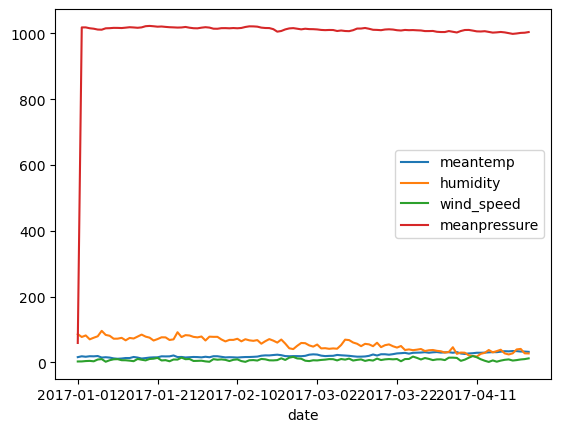

In [24]:
df.plot()

# Stationarity

Checking if the mean is constant or having trend (linear or non-linear). Because most of the classical model such as the AR, MA, ARIMA , SARIMA.
We'll use Dickey-Fuller test to check for stationarity.

In [61]:
def tsa_roll(df, collabel, points=7):
    import matplotlib.pyplot as plt
    
    roll_mean = df[collabel].rolling(points).mean()
    roll_std = df[collabel].rolling(points).std()
    
    plt.plot(df[collabel], label = f"Original {collabel} data", color="blue")
    plt.plot(roll_mean, label = f"Rolling {collabel} mean", color="red")
    plt.plot(roll_std, label = f"Rolling {collabel} std.deviation", color="black")
    plt.legend()
    plt.show()
    

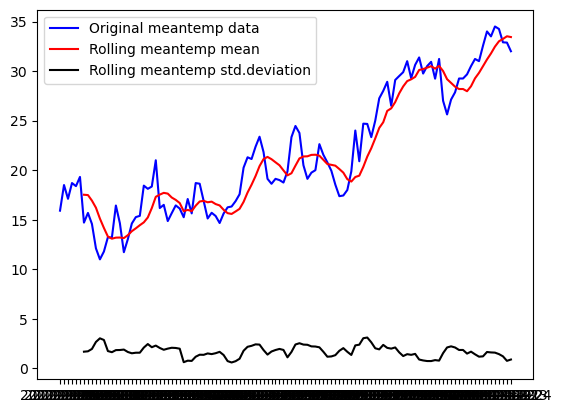

In [62]:
tsa_roll(df, 'meantemp')

In [9]:
def tsa_dftest(df, method='AIC'):
    from statsmodels.tsa.stattools import adfuller
    import pandas as pd
    adft = adfuller(df,autolag = method)
    output = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']],
                           "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    return output

In [10]:
tsa_dftest(df['meantemp'])

,Values,Metric
0,-1.096474,Test Statistics
1,0.716476,p-value
2,0.000000,No. of lags used
3,113.000000,Number of observations used
4,-3.489590,critical value (1%)
5,-2.887477,critical value (5%)
6,-2.580604,critical value (10%)


Our p-value is greater than 5% which means that the mean temperature is not stationary. We can see this in the graph above and observe that the rolling mean is actually increasing which support our conclusion that the mean is not constant.

# Autocorrelation
Autocorrelation is normally used to find which lag of time in the past has a strong relation with the present value today. 

In [54]:
def tsa_acf(df, collabel, nmax=10):
    import statsmodels.api as sm  
    
    sm.graphics.tsa.plot_acf(df[collabel], lags = nmax)
    plt.grid()
    plt.title(f"Autocorrelation of {collabel}")
    
    plt.show()
        

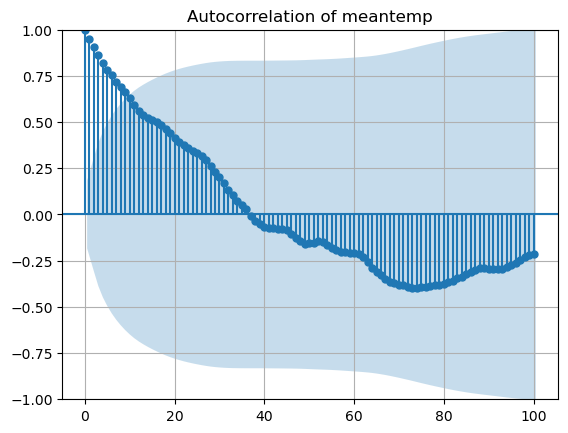

In [57]:
tsa_acf(df,'meantemp', 100)

# Time Series decompose

The time series can be decompose into many ways, one of it is to decompose the series into seasonal and trend.

Our time series will be as follow:

if additive model,
$$ Y_{t} = S_{t} + T_{t} + W_{t} $$.

if multiplicative model
$$ Y_{t} = S_{t} * T_{t} * W_{t} $$.

Where $Y(t)$ = the observation at time t,

$S(t)$ = the seasonal effect at time t,

$T(t)$ = the trend effect at time t,

$W(t)$ = the white noise or randomness or error at time t.


In [68]:
def tsa_decompose(df, collabel, n=7, mod = 'additive'):
    import matplotlib.pyplot as plt
    from statsmodels.tsa.seasonal import seasonal_decompose
    
    decompose = seasonal_decompose(df[collabel], model=mod, period=n)
    decompose.plot()
    plt.show()

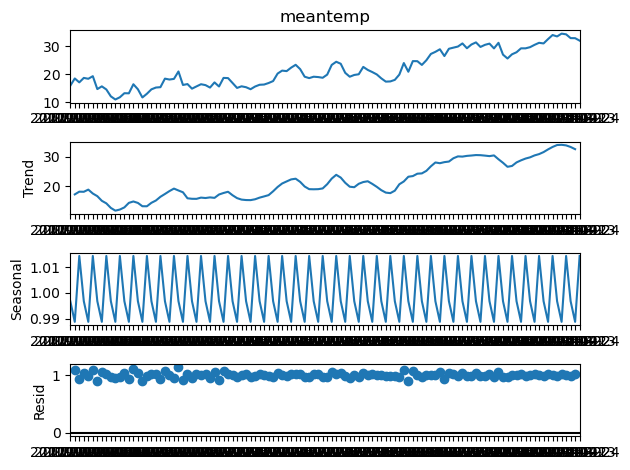

In [70]:
tsa_decompose(df,'meantemp', 3, 'multiplicative')

# Autoregressive model

For AR(1), this model is written as 

$$Y_{t} = \phi_{t} Y_{t-1} + W_{t}$$

Where Y(t) is the observation at time t, 

$\phi (t)$ is the coefficient for the past realization,

W(t) is the white noise.

For AR(2), we can add extra equation which is 
$$Y_{t} = \phi_{t} Y_{t-1} + W_{t}$$
$$Y_{t-1} = \phi_{t-1} Y_{t-2} + W_{t-1}$$

expressing AR(2) in terms of $Y_{t}$, we'll obtain the AR(2) to be just

$$Y_{t} = \phi_{t}\phi_{t-1} Y_{t-2} + W_{t} +\phi_{t} W_{t-1}$$

We can write a general expression for AR(k) to be

$$Y_{t} = Y_{t-k}\prod_{i=0}^{k} \phi_{t-i} + \sum_{i=0}^{k-1}(\phi_{t-i} W_{t-i-1})$$